<a href="https://colab.research.google.com/github/Marwahaoudi/project-in-Transformers-BERT-ELMo-GPT-etc/blob/main/BERT_ELMo_GPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers scikit-learn matplotlib


In [ ]:
!git clone https://github.com/Marwahaoudi/project-in-Transformers-BERT-ELMo-GPT-etc.git



Cloning into 'project-in-Transformers-BERT-ELMo-GPT-etc'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!git clone https://github.com/Marwahaoudi/project-in-Transformers-BERT-ELMo-GPT-etc.git

Cloning into 'project-in-Transformers-BERT-ELMo-GPT-etc'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [ ]:
!ls

project-in-Transformers-BERT-ELMo-GPT-etc  sample_data


In [ ]:
cd project-in-Transformers-BERT-ELMo-GPT-etc/


/content/project-in-Transformers-BERT-ELMo-GPT-etc


In [ ]:
!ls


README.md


Entraînement sur : cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/5
Train Loss: 0.7128 | Val Loss: 0.6907
Accuracy: 0.5000 | Precision: 0.5000 | Recall: 1.0000 | F1: 0.6667

Epoch 2/5
Train Loss: 0.6721 | Val Loss: 0.6887
Accuracy: 0.5000 | Precision: 0.5000 | Recall: 1.0000 | F1: 0.6667

Epoch 3/5
Train Loss: 0.6607 | Val Loss: 0.6891
Accuracy: 0.5000 | Precision: 0.5000 | Recall: 1.0000 | F1: 0.6667


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classifi


Epoch 4/5
Train Loss: 0.6177 | Val Loss: 0.6898
Accuracy: 0.5000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000

Epoch 5/5
Train Loss: 0.6256 | Val Loss: 0.6916
Accuracy: 0.5000 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000

Rapport de classification :
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.00      0.00      0.00         1

    accuracy                           0.50         2
   macro avg       0.25      0.50      0.33         2
weighted avg       0.25      0.50      0.33         2



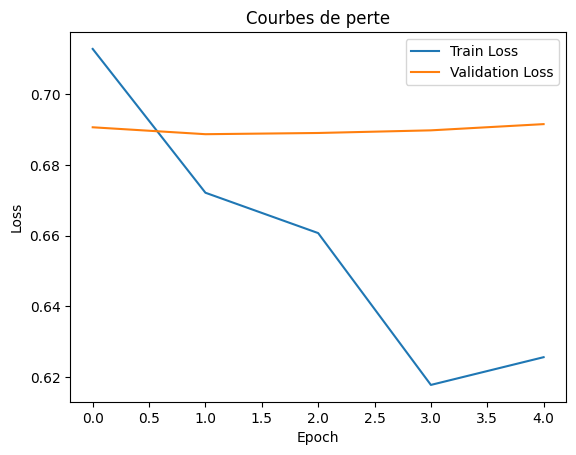


Modèle sauvegardé dans le dossier 'sentiment_bert'.
Texte : I really enjoyed this movie
Label prédit : positive

Texte : I hate this movie
Label prédit : negative



In [ ]:
import torch
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import matplotlib.pyplot as plt
import json

# Vérifie si CUDA est disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Entraînement sur : {device}")

# Initialisation du tokenizer et du modèle multilingue BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=2)
model.to(device)

# Données d'exemple
texts = [
    "I really enjoyed this movie",
    "I hate this movie",
    "The movie was great",
    "I love this movie",
    "I dislike this movie",
    "This movie is awful",
    "What a fantastic movie",
    "I can't stand this movie",
    "I had a great time",
    "This movie was terrible"
]

labels = [1, 0, 1, 1, 0, 0, 1, 0, 1, 0]  # 1 pour positif, 0 pour négatif

# Paramètres d'entraînement
epochs = 5
batch_size = 4
learning_rate = 2e-5
weight_decay = 0.01

# Séparation des données
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2)

# Tokenisation
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

# Création des datasets
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels)
)
val_dataset = TensorDataset(
    torch.tensor(val_encodings['input_ids']),
    torch.tensor(val_encodings['attention_mask']),
    torch.tensor(val_labels)
)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Optimiseur et scheduler
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss()

# Pour traquer les pertes
train_losses = []
val_losses = []

# Entraînement
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids, attention_mask, labels_batch = [x.to(device) for x in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels_batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
    train_losses.append(total_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels_list = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels_batch = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels_batch)
            loss = outputs.loss
            val_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels_list.extend(labels_batch.cpu().numpy())
    val_losses.append(val_loss / len(val_loader))

    # Métriques
    accuracy = accuracy_score(val_labels_list, val_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(val_labels_list, val_preds, average='binary')
    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_losses[-1]:.4f}")
    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")

# Affichage du rapport complet
print("\nRapport de classification :")
print(classification_report(val_labels_list, val_preds))

# Courbes de loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Courbes de perte')
plt.legend()
plt.show()

# Sauvegarde des métriques
metrics = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1
}
with open("metrics.json", "w") as f:
    json.dump(metrics, f)

# Sauvegarde du modèle
model.save_pretrained("sentiment_bert")
tokenizer.save_pretrained("sentiment_bert")
print("\nModèle sauvegardé dans le dossier 'sentiment_bert'.")

# Fonction de prédiction
def predict(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=1).item()
    return "positive" if prediction == 1 else "negative"

# Test de prédiction
test_texts = ["I really enjoyed this movie", "I hate this movie"]
for text in test_texts:
    print(f"Texte : {text}")
    print(f"Label prédit : {predict(text)}\n")